In [1]:
library(tidyverse)
library(ncdf4)
library(viridis)
library(fields)

Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.1
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: viridisLite

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.5-1 (2019-12-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwar

In [2]:
nc <- nc_open("data/Zinser_SizeDist_calibrated-26-6.nc")
PAR   <- ncvar_get(nc,'PAR')
w_obs <- ncvar_get(nc,'w_obs')
m     <- ncvar_get(nc,'m')
delta_v_inv <- ncvar_get(nc,'delta_v_inv')
v_min       <- ncvar_get(nc,'v_min')
time  <- ncvar_get(nc,'time')
time <- as.POSIXct(time*60, origin="2009-05-01")
delta_v <- 1/delta_v_inv
v       <- v_min*2^(0:25*delta_v) 

In [3]:
df <- read.csv("data/Zinser_Figure2A.csv")
abundance <- rowMeans(df[,c(3,2)]) # mean of culture A and B
clean <- smooth.spline(time, abundance, df=15) # smooth abundance data using spline


df2 <- read.csv("data/Zinser_Figure3.csv")


- ### Equation division rate (assuming exponential growth)
$$
DR = ln(\frac{N_1/N_0}t)

In [4]:
dr <- diff(log(clean$y))/diff(clean$x/3600) # calculate hourly division rate
dr[which(dr < 0)] <- 0

[1] "Division rate =  0.65 / day"


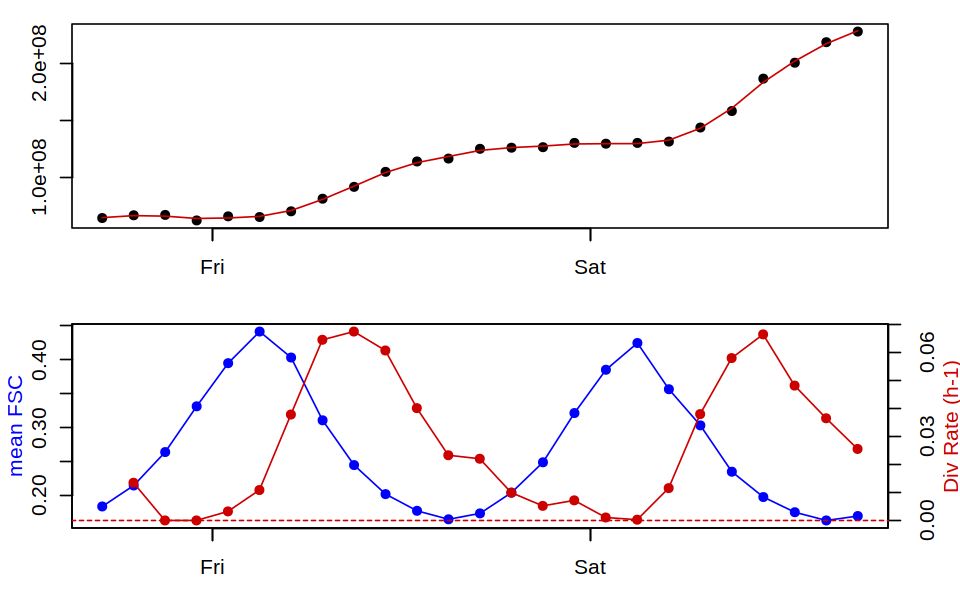

In [5]:
options(repr.plot.width = 8, repr.plot.height = 5)

par(mfrow=c(2,1), mar=c(3,3,1,3))
plot(time, abundance, pch=NA)
#polygon(x=rep(c(1200,1800,2640,3240),each=2), y=rep(c(1,10^9,10^9,1),2), border=NA, col='lightgrey')
points(time, abundance, pch=16)
lines(clean,col="red3" )
plot(time, df[,c(4)], pch=NA, xlab=NA, ylab=NA)
#polygon(x=rep(c(1200,1800,2640,3240),each=2), y=rep(c(-1,1,1,-1),2), border=NA, col='lightgrey')
lines(time, df[,c(4)], col='blue1', type="o", pch=16)
par(new=T)
plot(x=time[-1]-50,y=dr, type='o', pch=16, xaxt='n', yaxt='n', col="red3", xlab=NA, ylab=NA, xlim=range(time))
axis(4) 
mtext("Div Rate (h-1)", 4,2, col="red3")
mtext("mean FSC", 2,2, col="blue1")
abline(h=0, lty=2,col="red3")
print(paste("Division rate = ",round(24*mean(dr),3), "/ day"))


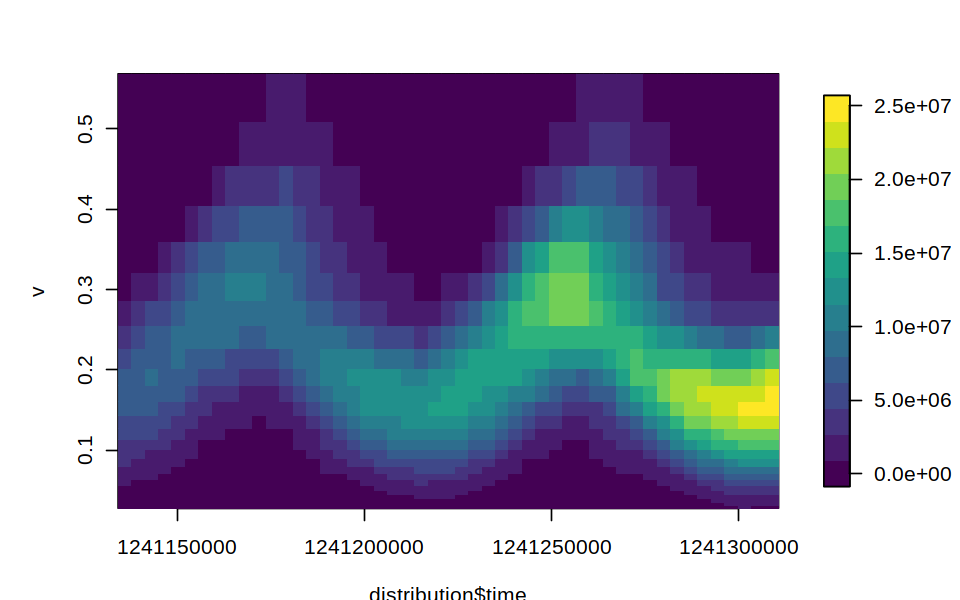

In [6]:
w_obs2 <- round(w_obs * abundance)
dist <- as.data.frame(w_obs2)
dist$time <- time

dist <- dist[,c(27,1:26)] # reorganize dataframe to be compatible with ssPopModel


resol.i <- 60 # in minutes
# Extrapolate dat based on "resol"
DF <- NULL
for(i in 1:dim(dist)[2]){
     df <- approx(dist$time, dist[,i], xout=seq(min(time), max(time), by=60*resol.i))
     DF <- cbind(DF, df$y)
    }
colnames(DF) <- c("time", v)

#write.csv(DF, "data/FSC_Array5_calibrated_1hr.csv", quote=F, row.names=F)

### select 1 day Size distribution
id <- c(1:25)   
distribution <- as.data.frame(DF[,])

options(repr.plot.width = 8, repr.plot.height = 5)
image.plot(x=distribution$time,y=v,z=as.matrix(distribution[,-c(1)]), col=viridis(15))

In [7]:
## PAR data
# resolution
resol <- 10 # in minutes

# select PAR data covering the range of the size distribution
par <- data.frame(time=time, par=PAR)
par <- subset(par, time  >= min(distribution$time) & time  < max(distribution$time))

# Change temporal resolution 
E <- approx(par$time, par$par, xout=seq(min(par$time), max(par$time), by=60*resol))

# smooth spline
ep <- smooth.spline(E, all.knots=TRUE)
Edata <- ep$y
Edata[Edata < 0] <- 0

# #plot
# options(repr.plot.width = 8, repr.plot.height = 8)
# plot(par$time,par$par, type='p', xlab=NA, ylab="Light")
# points(ep$x,Edata, col=4, lwd=3)

In [8]:
source("scripts/functions_model.R")

output <- determine_opt_para(distribution,Edata,resol)

Loading required package: DEoptim

Loading required package: parallel


DEoptim package
Differential Evolution algorithm in R
Authors: D. Ardia, K. Mullen, B. Peterson and J. Ulrich




[1] "Optimizing gmax, dmax, b and E_star"
Iteration: 10 bestvalit: 91744.481791 bestmemit:    0.425861    0.054140    0.314573    0.998383
Iteration: 20 bestvalit: 90480.958032 bestmemit:    0.427845    0.068150    0.359806    0.869956
Iteration: 30 bestvalit: 90131.939896 bestmemit:    0.507200    0.079095    0.366654    0.983146
Iteration: 40 bestvalit: 90043.571059 bestmemit:    0.229162    0.074435    0.337177    0.428916
Iteration: 50 bestvalit: 89992.141722 bestmemit:    0.286557    0.069243    0.333184    0.569080
Iteration: 60 bestvalit: 89966.759763 bestmemit:    0.299951    0.070662    0.336323    0.581262
Iteration: 70 bestvalit: 89961.510204 bestmemit:    0.226559    0.071258    0.337177    0.439889
Iteration: 80 bestvalit: 89959.569471 bestmemit:    0.150144    0.072650    0.340148    0.291277
Iteration: 90 bestvalit: 89959.565315 bestmemit:    0.150144    0.072838    0.340148    0.291277
Iteration: 100 bestvalit: 89959.565315 bestmemit:    0.150144    0.072838    0.340148

In [9]:
params <- output$parameters
        gmax <- as.numeric(params[1]) 
        dmax <- as.numeric(params[2]) 
        b <- as.numeric(params[3]) 
        E_star <- as.numeric(params[4])

resnorm <- as.numeric(params[5])

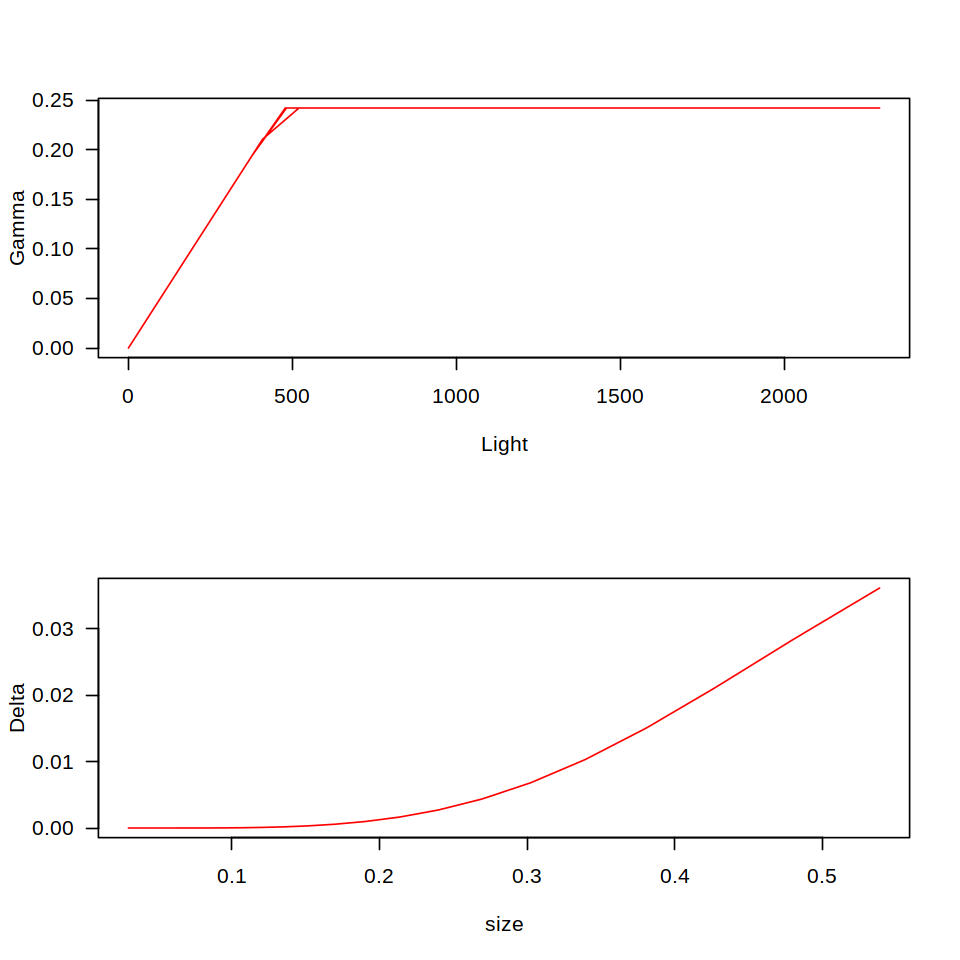

In [10]:
options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow=c(2,1))
plot(Edata*10, gamma_t(Edata*10, gmax, E_star), type='l', col='red', xlab="Light", ylab=paste("Gamma"), las=1)
plot(v, delta(v, dmax, b), type='l', col='red', xlab="size", ylab=paste("Delta"), las=1)    

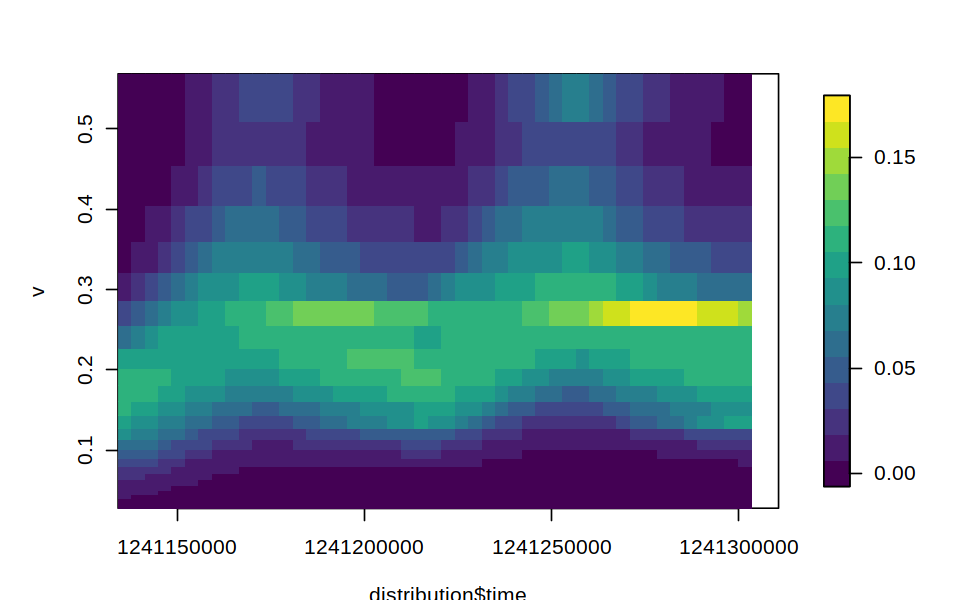

In [11]:
### plot size distribution
PSD <- output$PSD
Nproj <- as.matrix(PSD[,-c(1)])

### plot frequency distribution
s2 <- round(apply(Nproj, 1, function(x) sum(x,na.rm=T)))
Vproj <- as.matrix(Nproj/s2)

options(repr.plot.width = 8, repr.plot.height = 5)
image.plot(x=distribution$time,y=v,z=as.matrix(Vproj), col=viridis(15))

[1] 19.28559


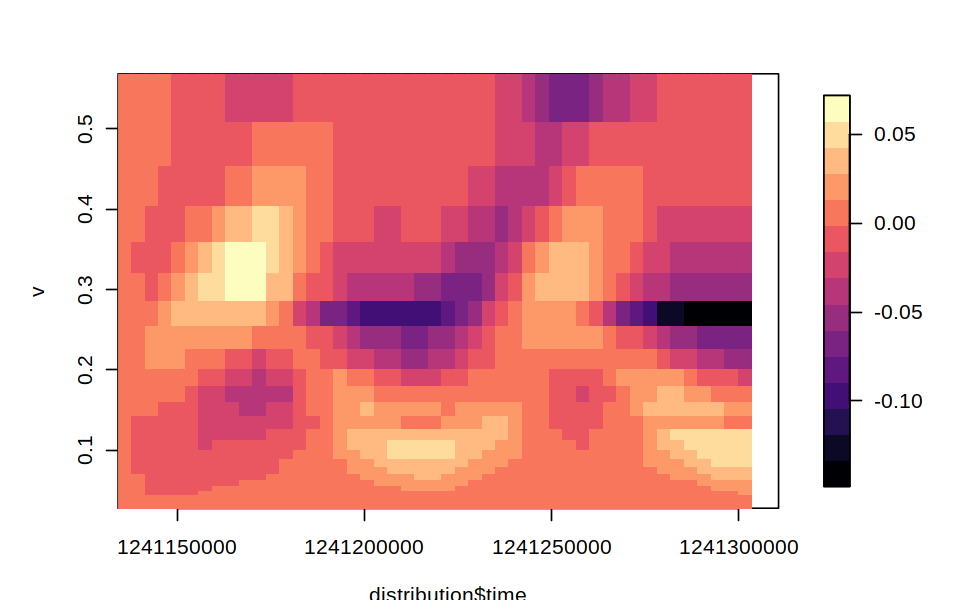

In [12]:
### plot difference Observed - Projected
s <- round(apply(distribution[,-c(1)], 1, function(x) sum(x,na.rm=T)))                   
z <- as.matrix(distribution[,-c(1)]/s) - Vproj

print(sum(abs(z), na.rm=T))                 
                 
options(repr.plot.width = 8, repr.plot.height = 5)
image.plot(x=distribution$time,y=v,z=z, col=viridis(15, option="A"))

[1] "daily growth rate= 0.69"


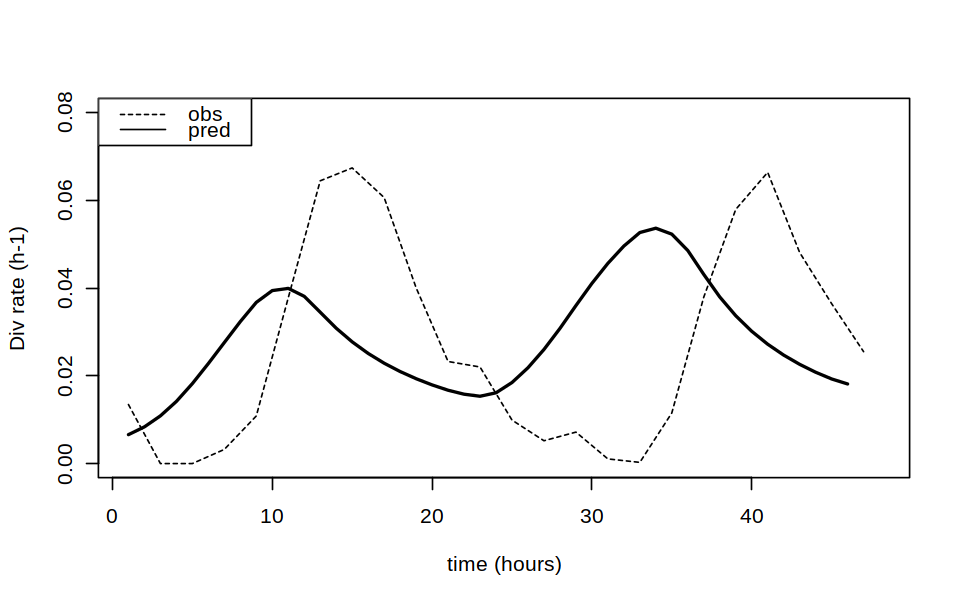

In [13]:
###############################
## Division rate calculation ##
###############################
mu_N <- diff(log(rowSums(PSD[,-c(1)], na.rm=T))) / as.numeric(diff(PSD$time)/3600)
d.mu_N <- 24*mean(mu_N[1:45], na.rm=T)

print(paste("daily growth rate=",round(d.mu_N,2)))

#plot
options(repr.plot.width = 8, repr.plot.height = 5)
plot(mu_N,type='l', ylim=c(0,0.08), xlab='time (hours)', ylab="Div rate (h-1)", lwd=2)
lines(seq(1,48,2), y=dr, lty=2)
legend("topleft",c("obs","pred"), lty=c(2,1))

[1] "Avg Quota 48 fg cell-1"
[1] "resp/growth = 0.4"


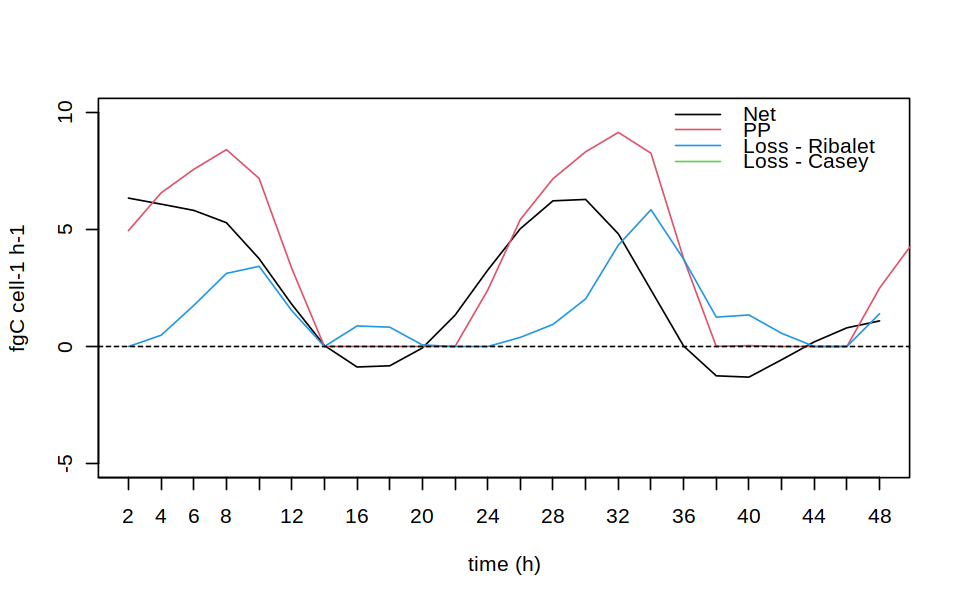

[1] "resp/growth = -0.4"


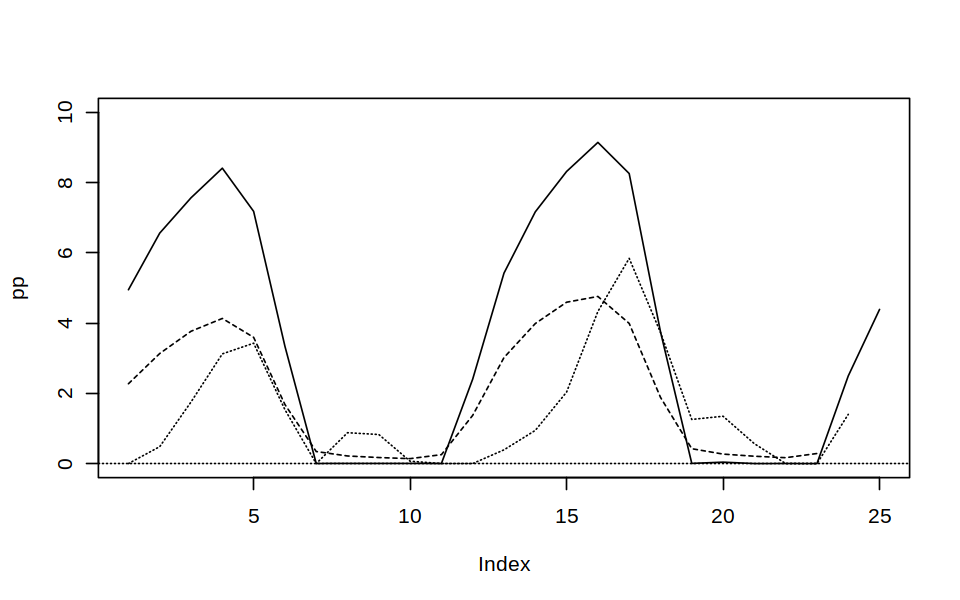

In [14]:
###########################################
## Growth & Respiration rate calculation ##
###########################################
correction <- 0.74 # correction to get quoats at 48 fg cell-1
c <- correction * 261 * v^0.861 # Menden-Deuer 

# 1 hr data interpolation, for compatibility with 1-hr model output
pp <- df2[,3]
pp[which(pp < 0)] <- 0
count <- clean$y

#  Calculate total biomass
s <- 0.5 ## smoothing parameter
biom1 <- diag(c) %*%  t(as.matrix(dist[,-c(1)]))
biom <- smooth.spline(colSums(biom1), spar=s)$y
obs.quotas <- biom / count
print(paste("Avg Quota", round(mean(obs.quotas)), "fg cell-1"))

## Option 1: Casey matlab code
pred.biom1 <- (obs.quotas[-25] + pp[-25]) * (count[-1] - diff(count))  + 0.5*(obs.quotas[-25] + pp[-25])*diff(count)
pred.quotas <- pred.biom1 / count[-1] 
resp1 <- -(pred.quotas-obs.quotas[-1])

## Option 2: BiomT1 = BiomT0 + ([PP + Loss] * countT0)
net <- diff(biom) / count[-25] # net
resp <- net - pp[-25] # resp + exudation
resp[which(resp > 0)] <- 0

print(paste("resp/growth =", round(mean(-resp, na.rm=T)/mean(pp, na.rm=T),2)))

options(repr.plot.width = 8, repr.plot.height = 5)
plot(net, ylim=c(-5,10), type='l', ylab="fgC cell-1 h-1", xlab="time (h)", xaxt="n") 
axis(1, at=seq(0,24,by=1), labels=seq(0,48,2))
lines(pp,col=2) 
lines(-resp, col=4) # Ribalet
#lines(-resp1, col=3) # Casey
abline(h=0, lty=2)
legend("topright", c("Net","PP","Loss - Ribalet", "Loss - Casey"), col=c(1,2,4,3), lwd=1, bty="n")

# # Proj Net growth rate
biom.proj <-  diag(c) %*%  t(Nproj) 
gr <- diff(colSums(biom.proj)) / rowSums(Nproj)[-49]
gr2 <- zoo::rollapply(gr, 2, mean, by=2) # change resolution to 2 hr

options(repr.plot.width = 8, repr.plot.height = 5)
plot(pp, type="l", ylim=c(0,10))
lines(gr2, lty=2); abline(h=0, lty=3)
lines(-resp, lty=3)
print(paste("resp/growth =", round(mean(resp, na.rm=T)/mean(pp, na.rm=T),2)))

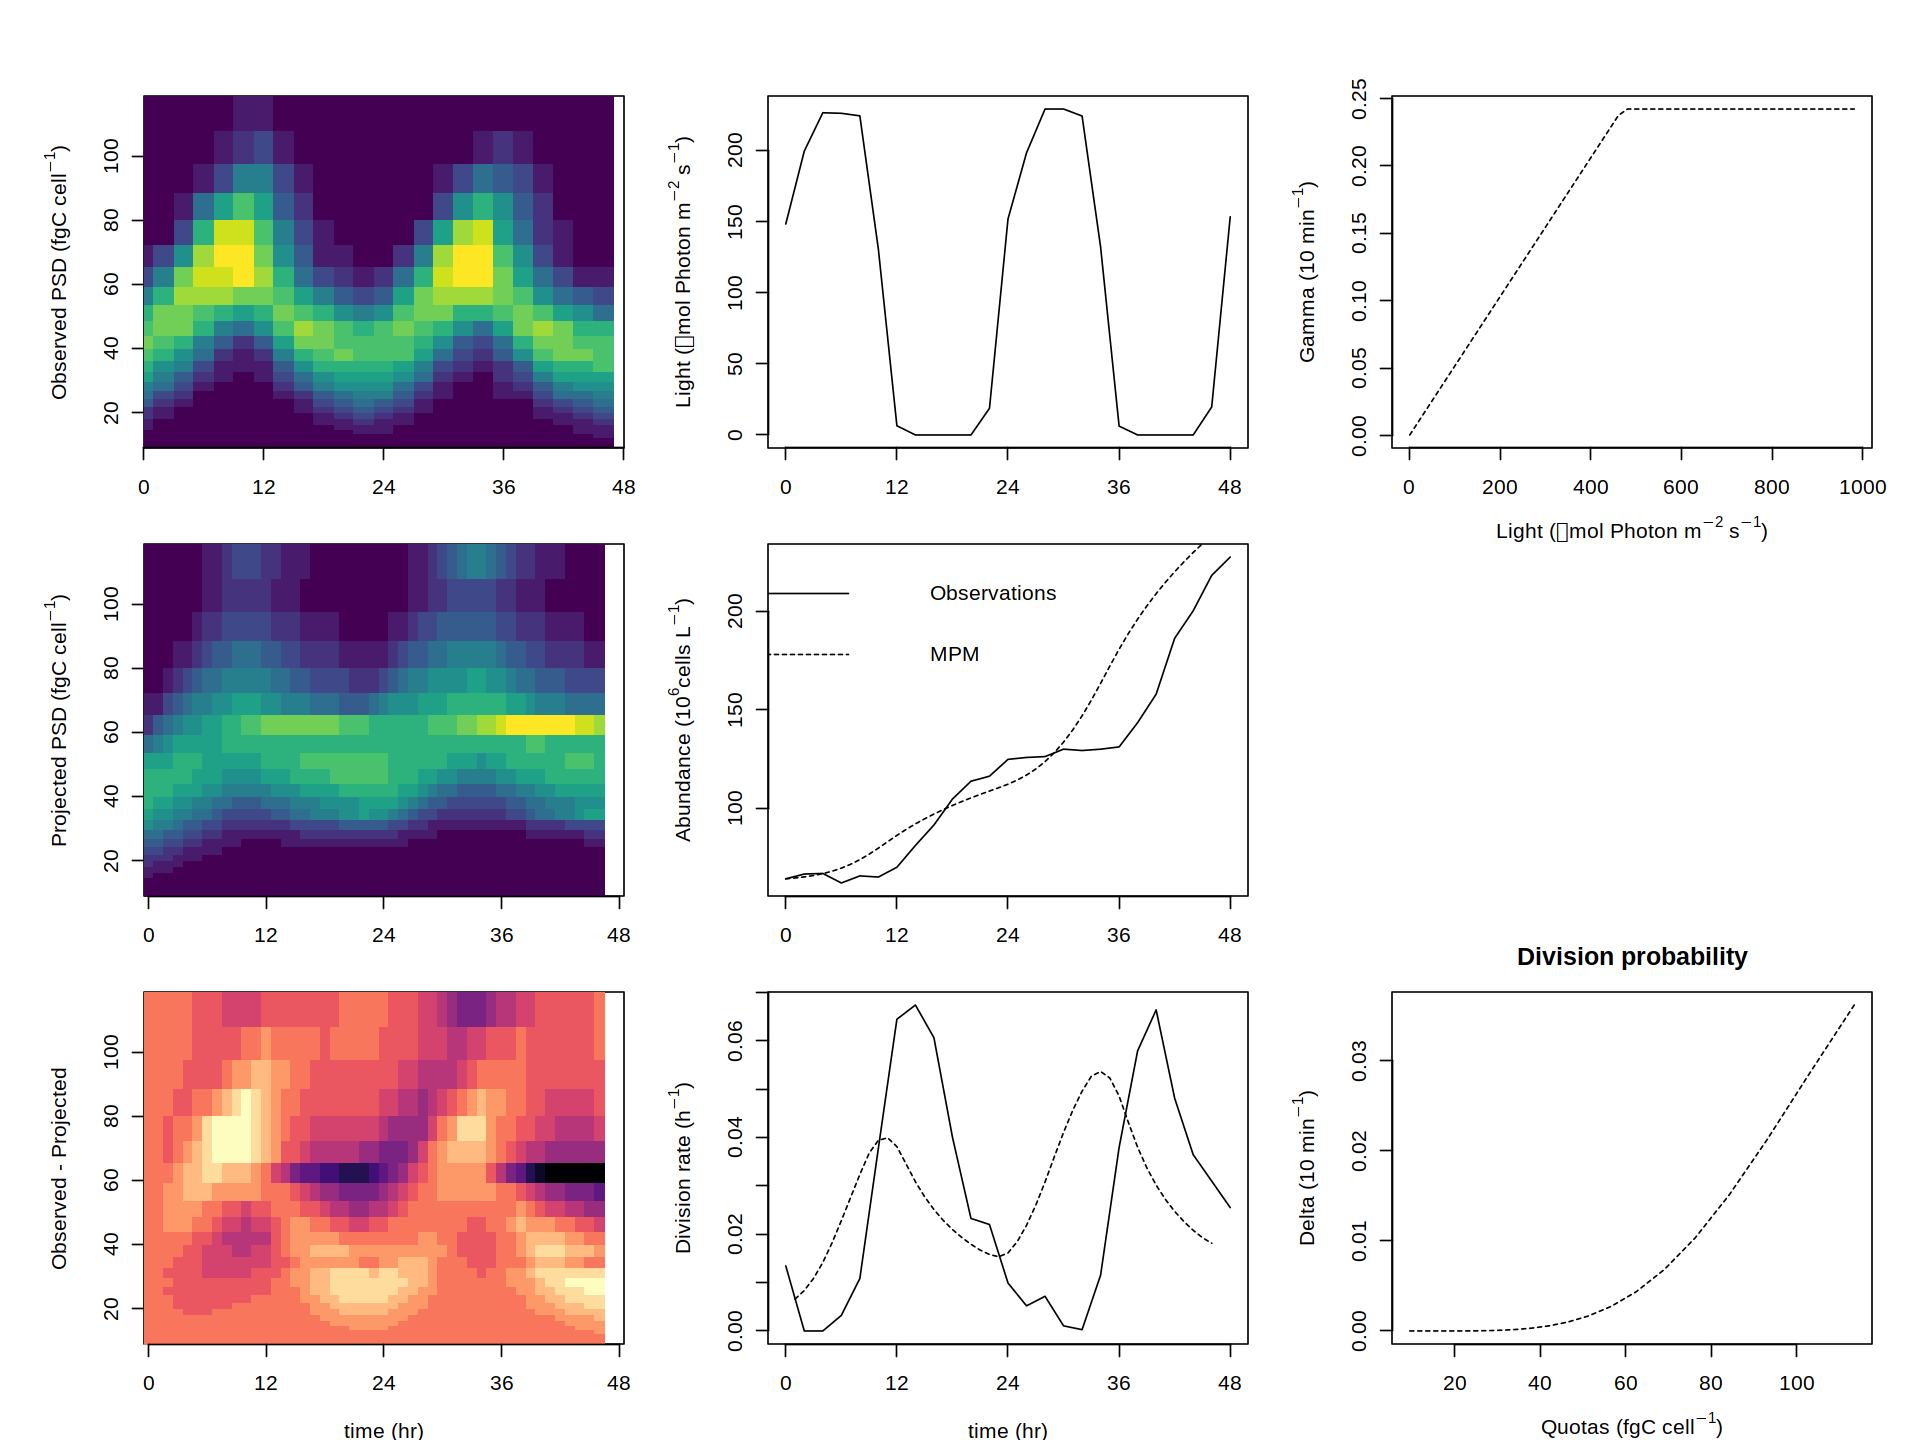

In [15]:
## Comparison Obs vs Model
#colorRampPalette(c("red3", "white","lightblue1"))(15)
r <- range(as.POSIXct(distribution$time, origin="1970-01-01"))
options(repr.plot.width = 16, repr.plot.height = 12)
layout(matrix(c(1:6,7,0,8), 3, 3, byrow = F))

par(mar=c(1,5,3,1), oma=c(3,1,1,1), lwd=1, cex=1)
image(x=time[-25],y=c,w_obs[-25,],col=viridis(15), ylab=expression('Observed PSD (fgC cell'^-1*')'), xaxt="n", xlim=range(time))
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
image(x=distribution$time,y=c,Vproj,col=viridis(15),ylab=expression('Projected PSD (fgC cell'^-1*')'), xaxt="n")
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
index <- cut(unlist(list(z)),15)
image(x=distribution$time,y=c,z,col=viridis(15, option="A"),ylab=expression('Observed - Projected'), xaxt="n")
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
mtext("time (hr)", 1, 3)

plot(time,PAR,type='l',xaxt='n', ylab=expression('Light ('*mu*'mol Photon m'^-2*' s'^-1*')'))
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
plot(time, abundance/10^6, type='l', xaxt="n", ylab=expression('Abundance (10'^6*'cells L'^-1*')'), xlim=range(time))
lines(distribution$time, rowSums(Nproj)/10^6, lty=2)
legend(r[1]-70000, y=240, legend=c("Observations","MPM"), lty=c(1,2), bty="n")
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
plot(x=time[-24],y=dr, type='l', xaxt='n',xlim=range(time), ylab=expression('Division rate (h'^-1*')'))
lines(x=distribution$time[-c(1)],y=mu_N, lty=2)
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
mtext("time (hr)", 1, 3)

plot(seq(1,1000,20), gamma_t(seq(1,1000,20), gmax, E_star), type='l', lty=2, ylab=expression('Gamma (10 min'^-1*')'))#, main="Growth probability")
mtext(expression('Light ('*mu*'mol Photon m'^-2*' s'^-1*')'), 1, 3)
plot(c, delta(v, dmax, b), type='l', lty=2, xlab="size", ylab=expression('Delta (10 min'^-1*')'), , main="Division probability") 
mtext(expression('Quotas (fgC cell'^-1*')'), 1,3)

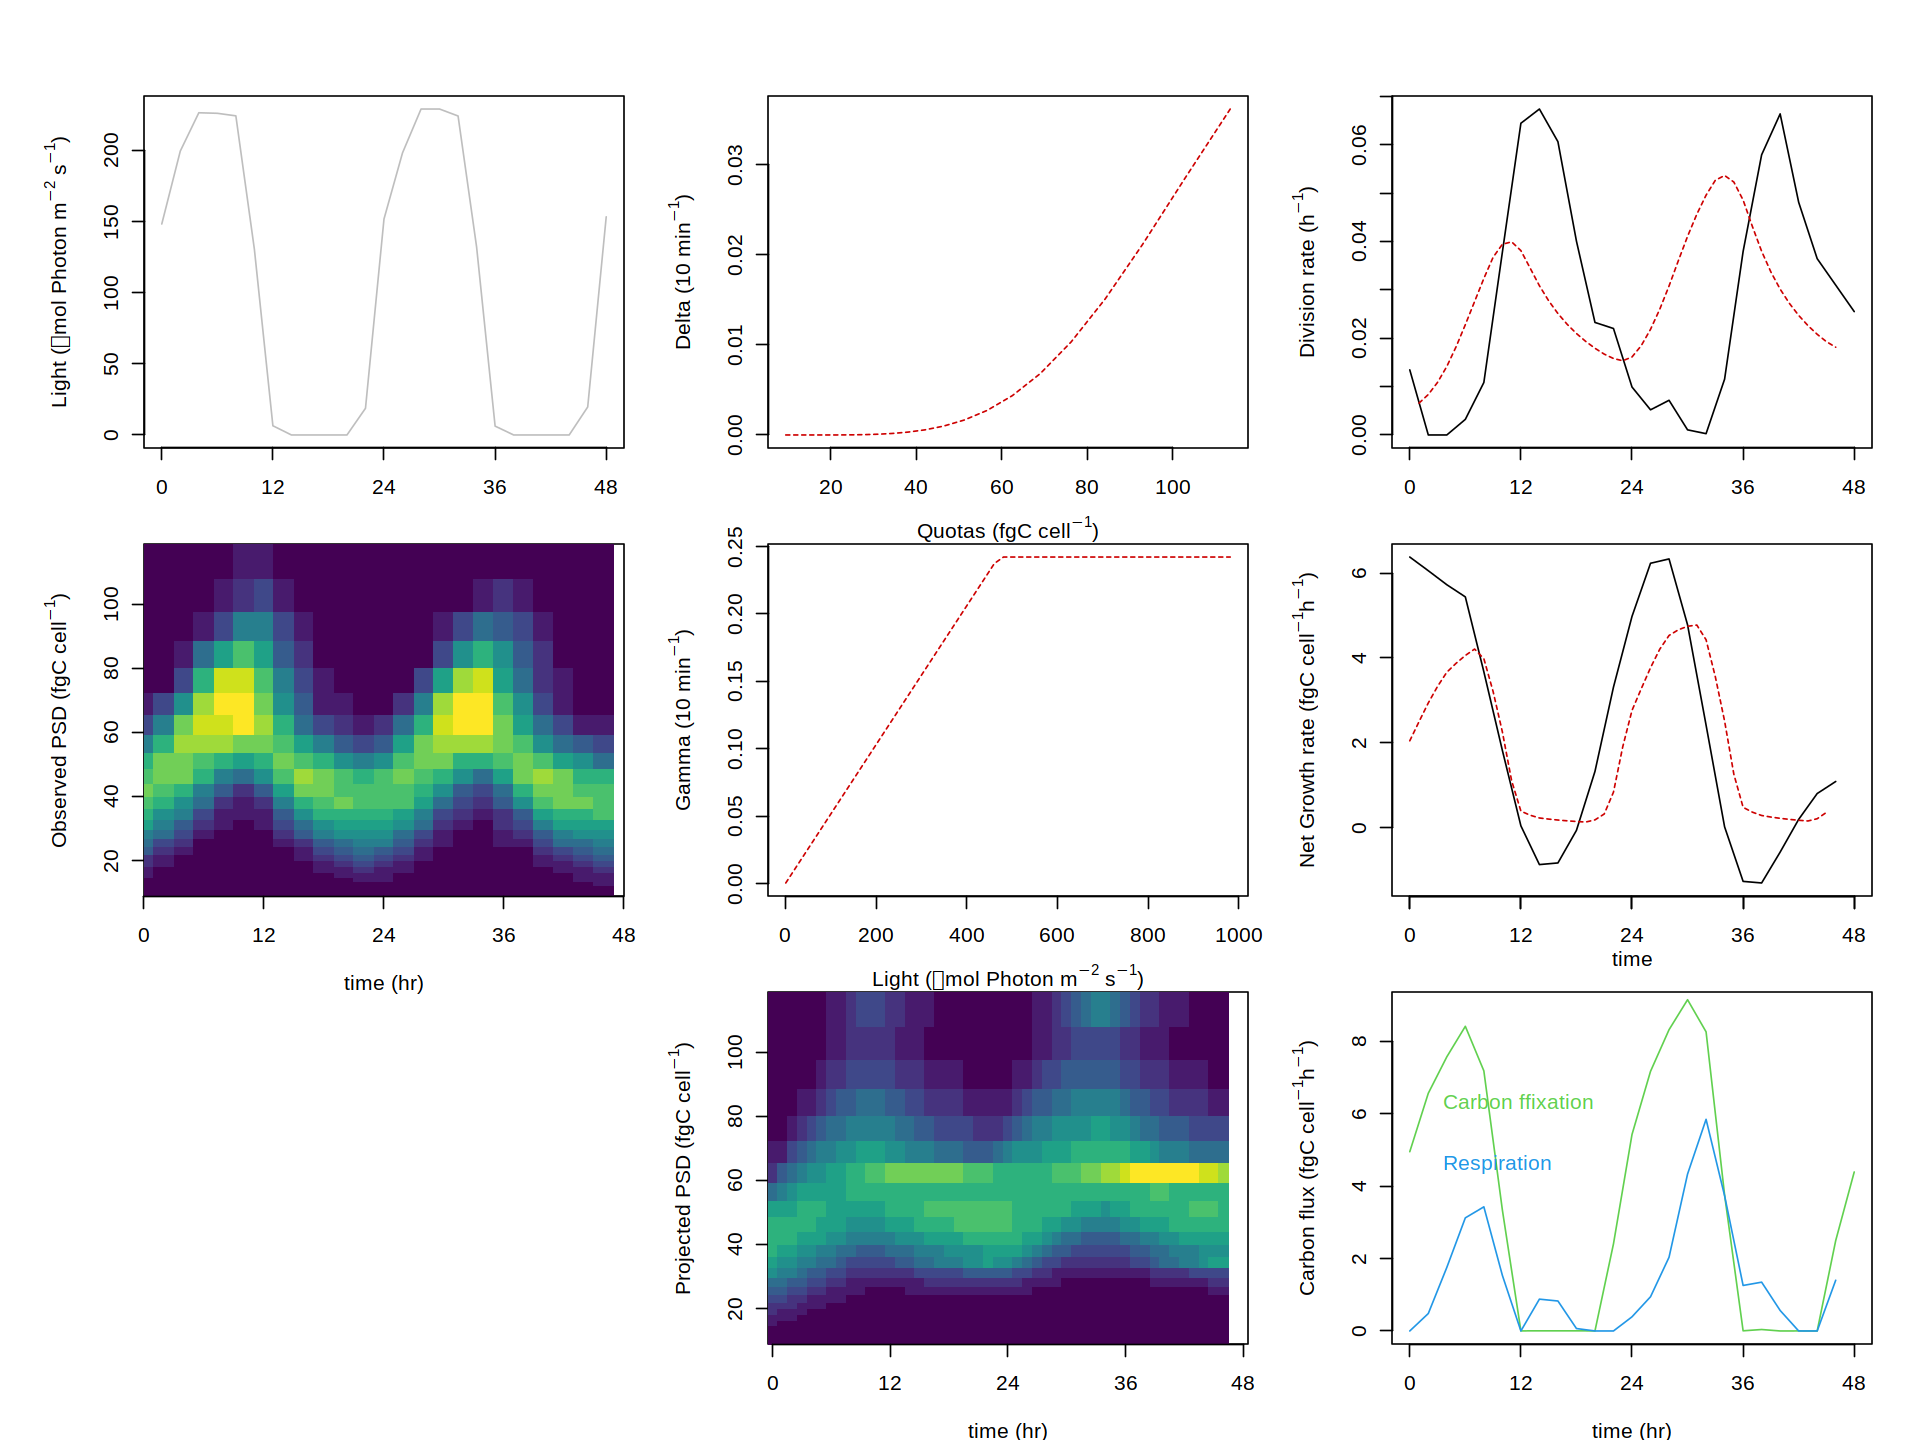

In [16]:
## Comparison Obs vs Model
#colorRampPalette(c("red3", "white","lightblue1"))(15)
r <- range(as.POSIXct(distribution$time, origin="1970-01-01"))
options(repr.plot.width = 16, repr.plot.height = 12)
layout(matrix(c(1,2,0,3:8), 3, 3, byrow = F))


par(mar=c(1,5,3,1), oma=c(3,1,1,1), lwd=1, cex=1)
plot(time,PAR,type='l',xaxt='n', ylab=expression('Light ('*mu*'mol Photon m'^-2*' s'^-1*')'), col="grey")
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
image(x=time[-25],y=c,w_obs[-25,],col=viridis(15), ylab=expression('Observed PSD (fgC cell'^-1*')'), xaxt="n", xlim=range(time))
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
# image(x=distribution$time,y=c,Vproj,col=viridis(15),ylab=expression('Projected PSD (fgC cell'^-1*')'), xaxt="n")
# # axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
# # index <- cut(unlist(list(z)),15)
# # image(x=distribution$time,y=c,z,col=viridis(15, option="A"),ylab=expression('Observed - Projected'), xaxt="n")
# axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
mtext("time (hr)", 1, 3)

plot(c, delta(v, dmax, b), type='l', lty=2, xlab="size", col="red3", ylab=expression('Delta (10 min'^-1*')'))#, main="Division probability") 
mtext(expression('Quotas (fgC cell'^-1*')'), 1,3)
plot(seq(1,1000,20), gamma_t(seq(1,1000,20), gmax, E_star), type='l',col="red3", lty=2, ylab=expression('Gamma (10 min'^-1*')'))#, main="Growth probability")
mtext(expression('Light ('*mu*'mol Photon m'^-2*' s'^-1*')'), 1, 3)
#legend(-400, y=0.5, c("Observations","model"), lty=c(1,2), bty="n")
image(x=distribution$time,y=c,Vproj,col=viridis(15, option="D"),ylab=expression('Projected PSD (fgC cell'^-1*')'), xaxt="n")
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
mtext("time (hr)", 1, 3)

# plot(time, abundance/10^6, type='l', xaxt="n", ,col="red3", ylab=expression('Abundance (10'^6*'cells L'^-1*')'), xlim=range(time))
# lines(distribution$time, rowSums(Nproj)/10^6, lty=2)
plot(x=time[-24],y=dr, type='l', xaxt='n',xlim=range(time), ylab=expression('Division rate (h'^-1*')'))
lines(x=distribution$time[-c(1)],y=mu_N, lty=2, col="red3")
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
#legend(r[1]-50000, y=0.06, legend=c("Observations","MPM"),col=c(1, "red3"),  lty=c(1,2), bty="n")

plot(x=dist$time[-25],diff(biom)/abundance[-25], xaxt="n", type='l',  xlim=range(time), ylab=expression('Net Growth rate (fgC cell'^-1*'h'^-1*')'))
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
mtext("time", 1, 2)
lines(x=distribution$time[-49],y=gr, lty=2, col="red3")
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=NA)


plot(x=time,y=pp, type='l', xaxt='n',  xlim=range(time), col=3, ylim=c(0,9), ylab=expression('Carbon flux (fgC cell'^-1*'h'^-1*')'))
lines(x=dist$time[-25], y = -resp, col=4)
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
mtext("time (hr)", 1, 3)
legend(r[1]-50000, y=8, legend=c("Carbon ffixation","Respiration"), text.col=c(3,4), bty="n")


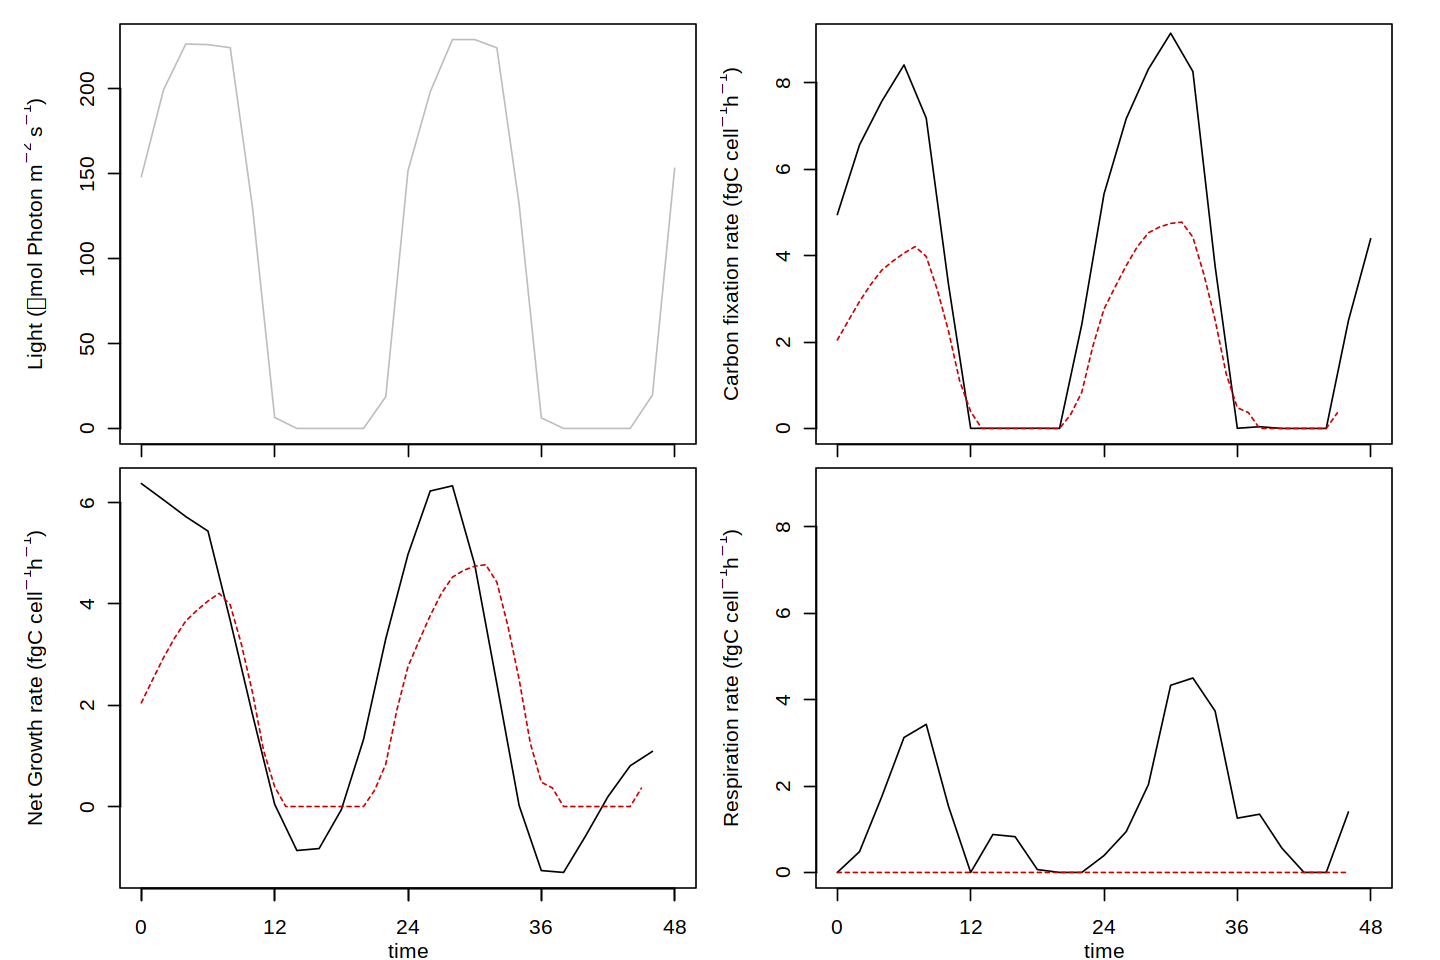

In [17]:
## Comparison Obs vs Model
#colorRampPalette(c("red3", "white","lightblue1"))(15)
r <- range(as.POSIXct(distribution$time, origin="1970-01-01"))
options(repr.plot.width = 12, repr.plot.height = 8)

gr[which(gr < 0.3)] <- 0
resp[which(resp < -5)] <- -4.5

par(mfrow=c(2,2), mar=c(1,4,0,1), oma=c(2,1,1,1), lwd=1, cex=1)
plot(time,PAR,type='l',xaxt='n', ylab=expression('Light ('*mu*'mol Photon m'^-2*' s'^-1*')'), col="grey")
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=NA)

plot(x=time,y=pp, type='l', xaxt='n',  xlim=range(time), ylim=c(0,9), ylab=expression('Carbon fixation rate (fgC cell'^-1*'h'^-1*')'))
lines(x=distribution$time[-49],y=gr, lty=2, col="red3")
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=NA)

plot(x=dist$time[-25],diff(biom)/abundance[-25], xaxt="n", type='l',  xlim=range(time), ylab=expression('Net Growth rate (fgC cell'^-1*'h'^-1*')'))
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
mtext("time", 1, 2)
lines(x=distribution$time[-49],y=gr, lty=2, col="red3")
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=NA)

plot(dist$time[-25], -resp, xaxt="n", type='l', ylim=c(0, 9), xlim=range(time), ylab=expression('Respiration rate (fgC cell'^-1*'h'^-1*')'))
lines(x=dist$time[-25], y = resp * 0, lty=2, col="red3")
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
mtext("time", 1, 2)

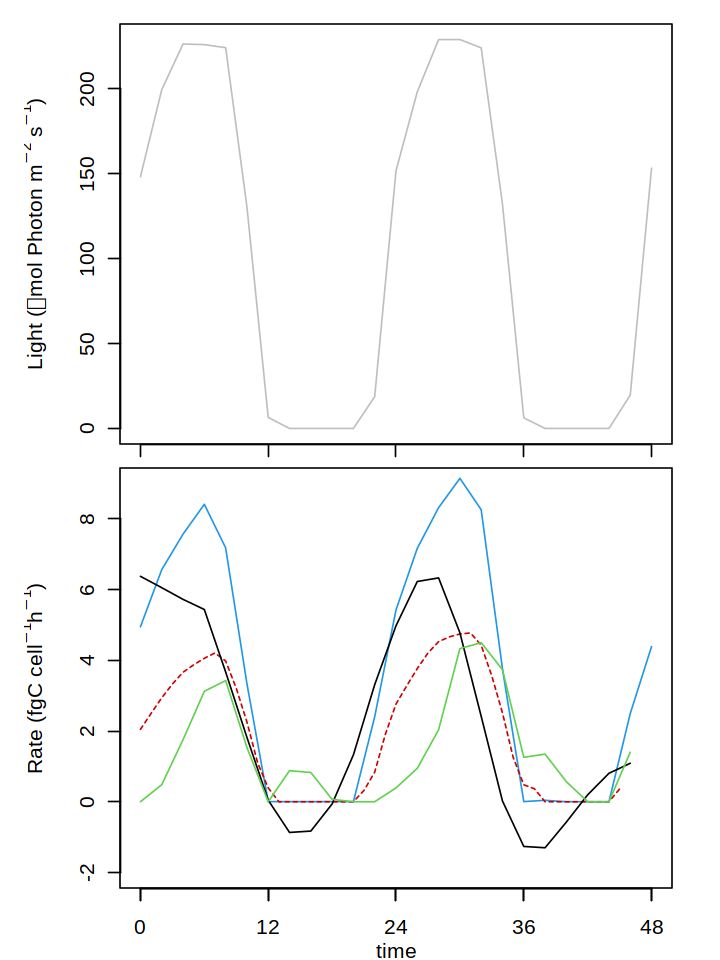

In [18]:
## Comparison Obs vs Model
#colorRampPalette(c("red3", "white","lightblue1"))(15)
r <- range(as.POSIXct(distribution$time, origin="1970-01-01"))
options(repr.plot.width = 6, repr.plot.height = 8)

gr[which(gr < 0.3)] <- 0
resp[which(resp < -5)] <- -4.5

par(mfrow=c(2,1), mar=c(1,4,0,1), oma=c(2,1,1,1), lwd=1, cex=1)
plot(time,PAR,type='l',xaxt='n', ylab=expression('Light ('*mu*'mol Photon m'^-2*' s'^-1*')'), col="grey")
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=NA)

plot(x=time,y=pp, type='l', xaxt='n',  xlim=range(time), col=4, ylim=c(-2,9), ylab=expression('Rate (fgC cell'^-1*'h'^-1*')'))
lines(x=distribution$time[-49],y=gr, lty=2, col="red3")
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=NA)

lines(x=dist$time[-25],diff(biom)/abundance[-25], col=1)
lines(dist$time[-25], -resp, col=3)
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
mtext("time", 1, 2)